In [1]:
# Load libraries
x<-c( 'tidyr',
     'ggplot2',
     'lubridate',
     'stringr',
     'dplyr')
try(lapply(x, require, character.only = TRUE), silent = T)

Loading required package: tidyr
Loading required package: ggplot2
Loading required package: lubridate

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: stringr
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

In [13]:
# Load dataset
df <- read.csv('./dataset.csv')
# r options for plotting in jupyter notebook - no need to run it on Rstudio or similar 
 options(repr.plot.width=5, repr.plot.height=2)

In [14]:
head(df)

datetime_local,orders,open,closed,holiday_name
2016-02-01T00:00:00Z,0,FALSE,FALSE,NA
2016-02-01T00:30:00Z,0,FALSE,FALSE,NA
2016-02-01T01:00:00Z,0,FALSE,FALSE,NA
2016-02-01T01:30:00Z,0,FALSE,FALSE,NA
2016-02-01T02:00:00Z,0,FALSE,FALSE,NA
2016-02-01T02:30:00Z,0,FALSE,FALSE,NA


## Plotting

In [15]:
# compute useful date measures
df %>%
# convert to datetime
    mutate(datetime_local = ymd_hms(datetime_local)) %>%
# get the day 
    mutate(day = floor_date(datetime_local, unit='day')) %>%
# get timebin
    mutate(time_bin = as.numeric(format(datetime_local, format='%H')) +
           as.numeric(format(datetime_local, format='%M'))/60) -> df

#### Plot over time 

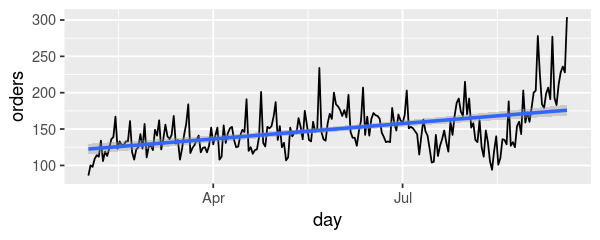

In [16]:
# aggregate, plot 
df %>%
# filter by open
    filter(open) %>%
# aggregate
    group_by(day) %>% 
    summarize(orders = sum(orders, na.rm=TRUE)) %>%
    ggplot(aes(day, orders)) + geom_line() + geom_smooth(method = "lm")

#### Plot distribution

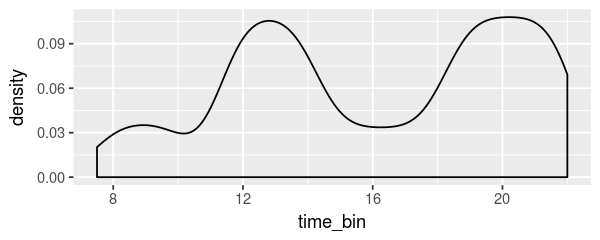

In [31]:
df %>% 
    filter(open) %>%
    ggplot(aes(time_bin)) + geom_density()

In [28]:
# bi-modal distribution
# extract the two maxes via k-means 
# use them as regressor 

## 2. Deal with "closed = TRUE" values

I want to check which order data is affected by closures - therefore I create a scatterplot in which I label the "closed" logical variables. The values in blue are the ones likely to impact the predictions.

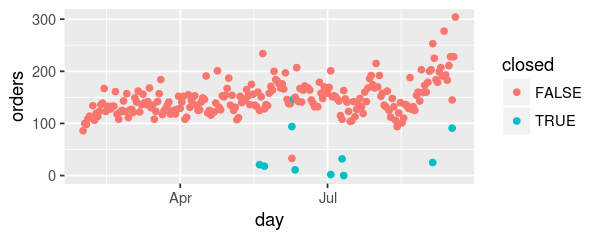

In [32]:
df %>%
    filter(open) %>%
    group_by(day, closed) %>% 
    summarize(orders = sum(orders, na.rm=TRUE)) %>%
    ggplot(aes(day, orders, colour=closed)) + geom_point() 

I try to apply some **transformations** and check if the scatterplot improves to better meet linearity assumptions. 
If I had skewed positive data I could have take logs... but here I have skewed non-negative data that include zeros. I try some different approaches - first a pseudo-logarithmic transformation thay knows how to deal with zero (and negative) values.

**Signed Logarithm**: the situation doesn't improve. I ideally want a transformation that **doesn't map 0 to 0**, ie. I want to artificially get rid of those zero. 

In [33]:
# declare the transformation function
signedlog10 = function(x) {
ifelse(abs(x) <= 1, 0, sign(x)*log10(abs(x)))
}

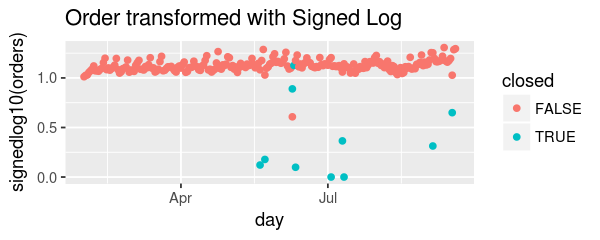

In [34]:
# aggregate, transform, plot
df %>%
    filter(open) %>%
    group_by(day, closed) %>% 
    summarize(orders = sum(signedlog10(orders), na.rm=TRUE)) %>%
    ggplot(aes(day, signedlog10(orders), colour=closed)) + geom_point() + ggtitle("Order transformed with Signed Log")

**Logarithm + constant**: I could try to apply a transformation that adds an **arbitrary constant** to the log base in order to avoid the scenario log(0).

In [35]:
log_const = function(x, undo=FALSE){
    constant <- 0.3
    if(undo==FALSE){
    return(log(x + constant))
    } else {
    return(exp(x - constant))
}
}

Warning message in log(x + constant):
“NaNs produced”Warning message in log(x + constant):
“NaNs produced”Warning message:
“Removed 3 rows containing missing values (geom_point).”

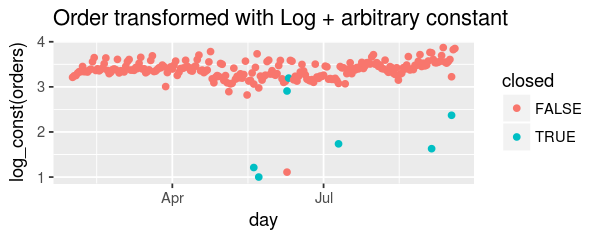

In [37]:
df %>%
    filter(open) %>%
    group_by(day, closed) %>% 
    summarize(orders = sum(log_const(orders), na.rm=TRUE)) %>%
    ggplot(aes(day, log_const(orders), colour=closed)) + geom_point()  + ggtitle("Order transformed with Log + arbitrary constant")

Looks better... - at least I don't have zero values. **NB!** A possible - and more elegant - approach would be to estimate the value of c in log(x+c) using the Box-Cox transformation with MLE. (https://en.wikipedia.org/wiki/Power_transform#Box.E2.80.93Cox_transformation)

# 3. Fit a model

In [38]:
# create a holiday dummy
df$holiday_dummies <- as.factor(ifelse(is.na(df$holiday_name),'0',df$holiday_name))
# check levels
unique(df$holiday_dummies)

[1] 0 4 5 1 6 7 3 2
Levels: 0 1 2 3 4 5 6 7

In [39]:
# create a training dataset restricting to opening hours
df %>%
    filter(open) -> training_df

I create a very **simple (=naive) model** that contains day, half-hourly time bins and holiday dummies.

In [40]:
# simple linear model version I
model_1 <- lm(log_const(orders) ~ 
              day +
              time_bin +
              holiday_dummies 
            ,data=training_df, na.action = na.exclude)

summary(model_1)


Call:
lm(formula = log_const(orders) ~ day + time_bin + holiday_dummies, 
    data = training_df, na.action = na.exclude)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0059 -0.6680  0.1418  0.6578  2.4067 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -1.524e+01  3.919e+00  -3.888 0.000103 ***
day               9.427e-09  2.675e-09   3.524 0.000429 ***
time_bin          1.911e-01  3.433e-03  55.680  < 2e-16 ***
holiday_dummies1 -8.090e-01  1.796e-01  -4.506 6.79e-06 ***
holiday_dummies2 -7.870e-01  2.032e-01  -3.874 0.000109 ***
holiday_dummies3 -8.438e-01  2.026e-01  -4.165 3.18e-05 ***
holiday_dummies4 -8.139e-01  2.028e-01  -4.013 6.09e-05 ***
holiday_dummies5 -2.666e-01  1.796e-01  -1.484 0.137757    
holiday_dummies6 -3.704e-01  1.795e-01  -2.063 0.039158 *  
holiday_dummies7 -8.636e-01  1.795e-01  -4.811 1.55e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9463 on 4260 

In [41]:
# Print RMSE for model 1 
summary(model_1)$sigma

[1] 0.9463266

Let's try to add some other covariates - interaction terms between time bins and day. To evaluate the model we could check the R squared and RMSE. The R squared is not a very good measure since one can always artificially inflate it (R squared is how much of the variance is explained) by adding extra covariates. We can rely on the **RMSE** which makes a good general purpose error metric for numerical predictions. In this case, we can simply call summary(model)$sigma for printing the metric. In the second model, the error is in fact smaller (0.9463 vs. 0.9433).

In [46]:
# simple linear model version II
model_2 <- lm(log_const(orders) ~ 
              day +
              time_bin +
              time_bin*day +
             holiday_dummies 
            ,data=training_df, na.action = na.exclude)

summary(model_2)


Call:
lm(formula = log_const(orders) ~ day + time_bin + time_bin * 
    day + holiday_dummies, data = training_df, na.action = na.exclude)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0673 -0.6842  0.1433  0.6451  2.4069 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       7.737e+01  1.801e+01   4.297 1.77e-05 ***
day              -5.381e-08  1.229e-08  -4.377 1.23e-05 ***
time_bin         -5.318e+00  1.046e+00  -5.086 3.81e-07 ***
holiday_dummies1 -8.237e-01  1.790e-01  -4.602 4.32e-06 ***
holiday_dummies2 -7.874e-01  2.025e-01  -3.888 0.000103 ***
holiday_dummies3 -8.448e-01  2.020e-01  -4.183 2.94e-05 ***
holiday_dummies4 -8.169e-01  2.022e-01  -4.041 5.41e-05 ***
holiday_dummies5 -2.835e-01  1.791e-01  -1.583 0.113443    
holiday_dummies6 -3.835e-01  1.790e-01  -2.143 0.032201 *  
holiday_dummies7 -8.724e-01  1.789e-01  -4.875 1.13e-06 ***
day:time_bin      3.762e-09  7.140e-10   5.269 1.44e-07 ***
---
Signif. codes:  0 ‘***’ 0.0

In [47]:
# RMSE for model 2 
summary(model_2)$sigma

[1] 0.943368

# 4. Generate predictions from 2016-09-19 till 2016-09-25

In [47]:
# This is a dirty way to create prediction. I created a csv containing days and timebins 
# for the week to forecast and I readjusted the type of variables (dummies to factor, day to POSIXct)
# in order to use the predict() command using the model_2 object.

forecast_df <- read.csv('/home/vincenzograsso/Desktop/forecast-task/forecast_df.csv')

In [48]:
# readjust the types
forecast_df$holiday_dummies <- as.factor(forecast_df$holiday_dummies)
forecast_df$day <- as.POSIXct(forecast_df$day)

In [49]:
forecast_df$forecast <- round(log_const(predict(model_2, newdata = forecast_df), undo=TRUE),0 )

In [50]:
head(forecast_df)

day,time_bin,holiday_dummies,forecast
2016-09-19,11.5,0,1
2016-09-19,12.0,0,2
2016-09-19,12.5,0,2
2016-09-19,13.0,0,2
2016-09-19,13.5,0,2
2016-09-19,14.0,0,3
